In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error

In [2]:
data = yf.download('^BVSP', '2007-01-01', '2024-03-21')
data = data[['Close']]
lag = 15

[*********************100%%**********************]  1 of 1 completed


In [3]:
data

,Close
Date,
2007-01-02,45383.0
2007-01-03,44445.0
2007-01-04,44020.0
2007-01-05,42245.0
2007-01-08,42830.0
...,...
2024-03-14,127690.0
2024-03-15,126742.0
2024-03-18,126954.0


In [4]:
data.head()

,Close
Date,
2007-01-02,45383.0
2007-01-03,44445.0
2007-01-04,44020.0
2007-01-05,42245.0
2007-01-08,42830.0


In [5]:
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80): len(data)])

In [6]:
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

In [7]:
model = pm.auto_arima(train['Close'], seasonal=True, m=lag)
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Forecast'])
test['forecast'] = forecast.values

c:\Users\Admin\OneDrive\Desktop\stock_market_analysis\sachinenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\OneDrive\Desktop\stock_market_analysis\sachinenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Admin\AppData\Local\Temp\ipykernel_38300\1139029889.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = forecast.values


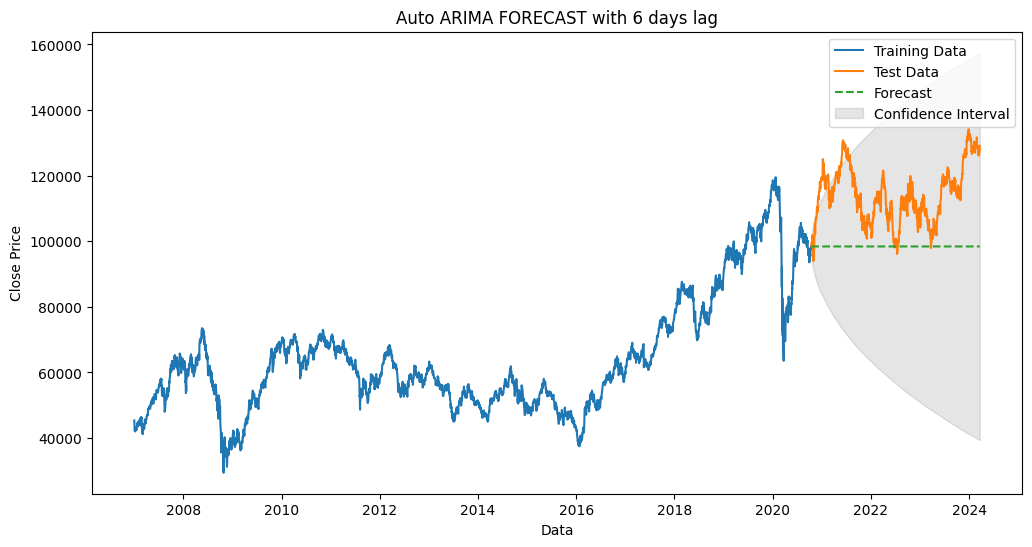

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label = 'Training Data')
plt.plot(test['Close'], label = 'Test Data')
plt.plot(test['forecast'], label = 'Forecast', linestyle = 'dashed')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color = 'k', alpha = 0.1, label = 'Confidence Interval')
plt.title('Auto ARIMA FORECAST with 6 days lag')
plt.xlabel('Data')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [9]:
arima_mse = mean_squared_error(test['Close'], forecast.values)
print("GRU Model RMSE : ", np.sqrt(arima_mse))

GRU Model RMSE :  17924.22396135134


In [10]:
def calculate_mape(true_value, predicted_value):
    abs_percentage_error = np.abs((true_value - predicted_value) / predicted_value)
    mape = np.mean(abs_percentage_error) * 100
    return mape 

In [11]:
arima_mape = calculate_mape(test['Close'], forecast.values)

In [12]:
print("ARIMA Model MAPE : {: .2f}%".format(arima_mape))

ARIMA Model MAPE :  16.07%


In [13]:
def calculate_mae(true_value, predicted_value):
    abs_error = np.abs(true_value - predicted_value)
    mae = np.mean(abs_error)
    return mae

In [14]:
arima_mae = calculate_mae(test['Close'], forecast.values)

In [15]:
print("ARIMA MAE : {: .2f}".format(arima_mae))

ARIMA MAE :  15815.77


In [16]:
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

In [17]:
arima_mase = calculate_mase(arima_mae, 15143.23)

In [18]:
print("ARIMA Model MASE : {: .2f}".format(arima_mase))

ARIMA Model MASE :  1.04


In [19]:
residual_arima = model.resid()

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [21]:
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape = (residual_arima_normalized.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))

c:\Users\Admin\OneDrive\Desktop\stock_market_analysis\sachinenv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
X_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, 1))
y_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, ))

In [24]:
model_lstm.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0323
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8314e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6567e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6115e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2626e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5326e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4746e-04
Epoch 8/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4375e-04
Epoch 9/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1668e-04
Epoch 10/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0355e-04
Epoch 11/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5118e-04
Epoch 12/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9222e-04
Epoch 13/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3138e-04
Epoch 14/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9821e-05
Epoch 15/300
54/54 

KeyboardInterrupt: 

In [ ]:
X_test = np.reshape(residual_arima_normalized[-len(test):], (len(test), 1, 1))
residuals_lstm_normalized = model_lstm.predict(X_test)
residuals_lstm = scaler.inverse_transform(residuals_lstm_normalized)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


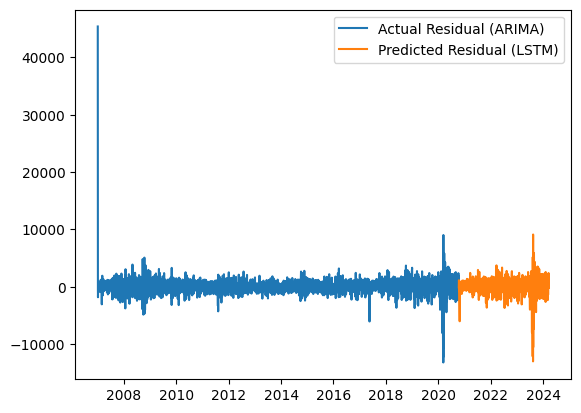

In [ ]:
plt.plot(residual_arima.index, residual_arima.values, label = "Actual Residual (ARIMA)")
plt.plot(test.index, residuals_lstm, label = "Predicted Residual (LSTM)")
plt.legend()
plt.show()

In [ ]:
residual_arima = model.resid()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape = (residual_arima_normalized.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))

c:\Users\Admin\Downloads\pmdarima-master\pmdarima-master\sachinenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_gru.compile(optimizer='adam', loss= 'mean_squared_error')

In [ ]:
X_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, 1))
y_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, ))

In [ ]:
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0223
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0518e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2814e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4629e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3377e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7799e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3088e-04
Epoch 8/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2067e-04
Epoch 9/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0997e-04
Epoch 10/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3929e-04
Epoch 11/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1208e-05
Epoch 12/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2627e-05
Epoch 13/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2126e-05
Epoch 14/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8380e-06
Epoch 15/300
54/54 ━━━━━━━━━━━━

In [ ]:
X_test = np.reshape(residual_arima_normalized[-len(test):], (len(test), 1, 1))
residuals_lstm_normalized = model_gru.predict(X_test)
residuals_lstm = scaler.inverse_transform(residuals_lstm_normalized)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


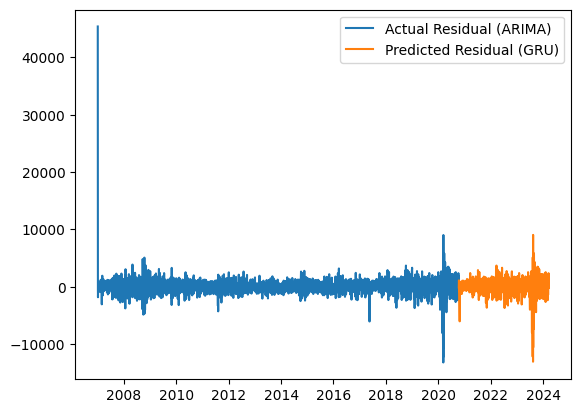

In [ ]:
plt.plot(residual_arima.index, residual_arima.values, label = "Actual Residual (ARIMA)")
plt.plot(test.index, residuals_lstm, label = "Predicted Residual (GRU)")
plt.legend()
plt.show()

In [ ]:
test['Forecast Hybrid'] = test['forecast'].values+np.hstack(residuals_lstm)
test['Forecast Hybrid Gru'] = test['forecast'].values+np.hstack(residuals_lstm_normalized)

C:\Users\Admin\AppData\Local\Temp\ipykernel_44008\2890411981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast Hybrid'] = test['forecast'].values+np.hstack(residuals_lstm)
C:\Users\Admin\AppData\Local\Temp\ipykernel_44008\2890411981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast Hybrid Gru'] = test['forecast'].values+np.hstack(residuals_lstm_normalized)


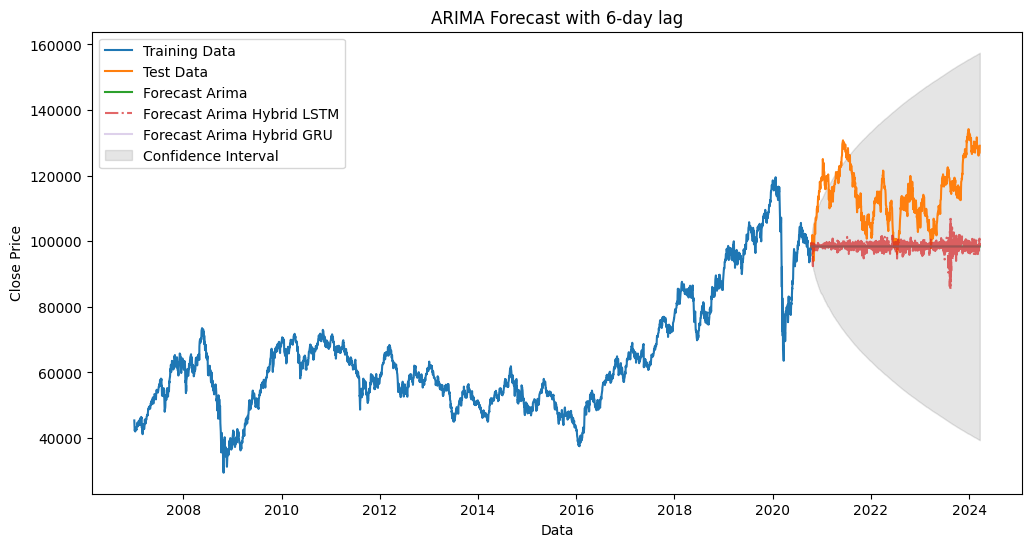

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train['Close'], label = 'Training Data')
plt.plot(test['Close'], label = 'Test Data')
plt.plot(test['forecast'], label = 'Forecast Arima', linestyle = 'solid')
plt.plot(test['Forecast Hybrid'], label = 'Forecast Arima Hybrid LSTM', linestyle = 'dashdot', alpha = 0.7)
plt.plot(test['Forecast Hybrid Gru'], label = 'Forecast Arima Hybrid GRU', linestyle = 'solid', alpha = 0.3)
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color = 'k', alpha = 0.1, label = 'Confidence Interval')
plt.title('ARIMA Forecast with 6-day lag')
plt.xlabel('Data')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
def calculate_mape(true_vaues, predicted_values):
    abs_percentage_errors = np.abs((true_vaues - predicted_values) / true_vaues)
    mape = np.mean(abs_percentage_errors) * 100
    return mape

In [ ]:
arimah_mape = calculate_mape(test['Close'], test['Forecast Hybrid'].values)
arimahg_mape = calculate_mape(test['Close'], test['Forecast Hybrid Gru'].values)

In [ ]:
print('ARIMA Model MAPE : {: .2f}%'.format(arimah_mape))
print('ARIMA GRU ModelMAPE : {: .2f}%'.format(arimahg_mape))

ARIMA Model MAPE :  13.36%
ARIMA GRU ModelMAPE :  13.38%


In [ ]:
def calculate_mae(true_value, predicted_value):
    abs_error = np.abs(true_value - predicted_value)
    mae = np.mean(abs_error)
    return mae

In [ ]:
arimah_mae = calculate_mae(test['Close'], test['Forecast Hybrid'].values)
arimahg_mae = calculate_mae(test['Close'], test['Forecast Hybrid Gru'].values)

In [ ]:
print('ARIMA Model MAE : {:.2f}'.format(arimah_mae))
print('ARIMA Model MAE : {:.2f}'.format(arimahg_mae))

ARIMA Model MAE : 15791.59
ARIMA Model MAE : 15815.55


In [ ]:
def calculate_mase(model_mae, baseline_mae):
    mase = model_mae / baseline_mae
    return mase

In [ ]:
arimah_mase = calculate_mase(arimahg_mae, 15143.23)
arimahg_mase = calculate_mase(arimahg_mae, 15143.23)

In [ ]:
print('ARIMA Model MASE : {:.2f}'.format(arimah_mase))
print('ARIMA GRU Model MASE : {:.2f}'.format(arimahg_mase))

ARIMA Model MASE : 1.04
ARIMA GRU Model MASE : 1.04


In [ ]:
arimah_mse = mean_squared_error(test['Close'], test['Forecast Hybrid'].values)
arimahg_mse = mean_squared_error(test['Close'], test['Forecast Hybrid Gru'].values)

In [ ]:
print('LSTM Arima Model RMSE : ', np.sqrt(arimah_mae))
print('GRU Arima Model RMSE : ', np.sqrt(arimahg_mae))

LSTM Arima Model RMSE :  125.66458009300918
GRU Arima Model RMSE :  125.75990848230649


In [ ]:
data2test = yf.download('^BVSP', '2024-03-20', '2024-03-23')
data2test = data2test[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [ ]:
len(data2test)

3

In [ ]:
time_index_train = data.index
time_index_test = data2test.index

ValueError: x and y must have same first dimension, but have shapes (3,) and (852,)

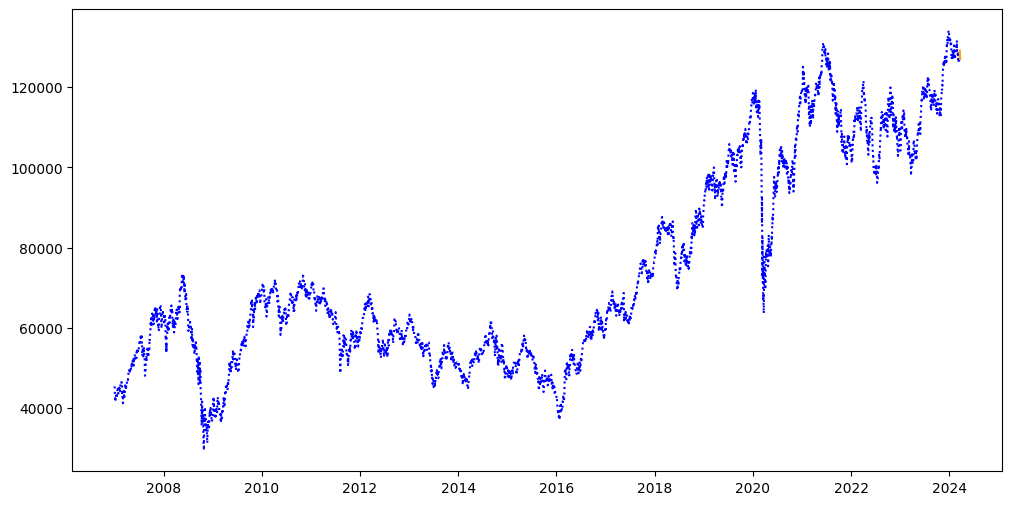

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(time_index_train, data, label = 'Actual Train Close', color = 'blue', linestyle = 'dotted')
plt.plot(time_index_test, data2test, label = 'Actual Test Close', color = 'orange')
plt.plot(time_index_test, forecast, label = 'Multi-Step Prediction Arima', color = 'green')
plt.title('Multi-Step LSTM Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
residual_arima = model.resid()
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units= 50, return_sequences=True, input_shape = (residual_arima_normalized.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))

c:\Users\Admin\Downloads\pmdarima-master\pmdarima-master\sachinenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
X_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, 1))
y_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1))

In [ ]:
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - loss: 0.0198
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 3.3144e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 3.0185e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 3.8762e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 3.2477e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6173e-04  
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 2.0897e-04
Epoch 8/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4611e-04
Epoch 9/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8303e-04
Epoch 10/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 6.9676e-05
Epoch 11/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0892e-05
Epoch 12/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8565e-05
Epoch 13/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0938e-05
Epoch 14/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5076e-06
Epoch 15/300
54

In [ ]:
X_test = np.reshape(residual_arima_normalized[-len(data2test):], (len(data2test), 1, 1))

In [ ]:
residual_gru_normalized = model_gru.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [ ]:
residual_gru = scaler.inverse_transform(residual_gru_normalized)

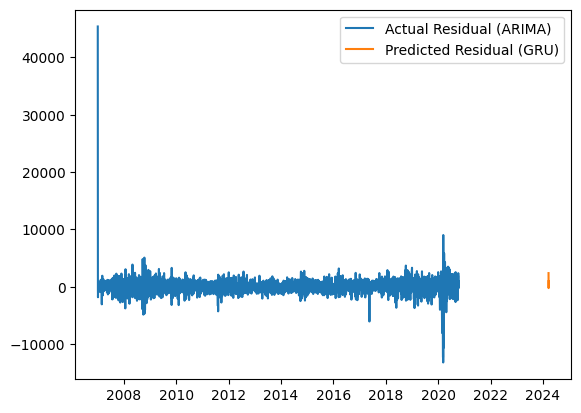

In [ ]:
plt.plot(residual_arima.index, residual_arima.values, label = 'Actual Residual (ARIMA)')
plt.plot(data2test.index, residual_gru, label = 'Predicted Residual (GRU)')
plt.legend()
plt.show()

In [ ]:
residual_arima = model.resid()
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(units= 50, return_sequences=True, input_shape = (residual_arima_normalized.shape[1], 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=1))

c:\Users\Admin\Downloads\pmdarima-master\pmdarima-master\sachinenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
X_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, 1))
y_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1))

In [ ]:
model_lstm.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0303
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 5.3241e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 3.5850e-04
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 4.8510e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 2.7697e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 2.7441e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 2.0397e-04
Epoch 8/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 2.2548e-04
Epoch 9/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 2.1340e-04
Epoch 10/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 2.0507e-04
Epoch 11/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 2.1976e-04
Epoch 12/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 1.5623e-04
Epoch 13/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 1.1279e-04
Epoch 14/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 1.0235e-04
Epoch

In [ ]:
X_test = np.reshape(residual_arima_normalized[-len(data2test):], (len(data2test), 1, 1))

In [ ]:
residual_lstm_normalized = model_lstm.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


In [ ]:
residual_lstm = scaler.inverse_transform(residual_lstm_normalized)

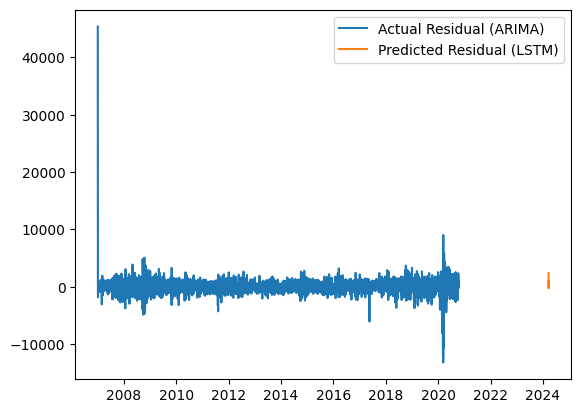

In [ ]:
plt.plot(residual_arima.index, residual_arima.values, label = 'Actual Residual (ARIMA)')
plt.plot(data2test.index, residual_lstm, label = 'Predicted Residual (LSTM)')
plt.legend()
plt.show()

In [ ]:
forecast_df['Forecast Hybrid'] = forecast_df['Forecast'].values+np.hstack(residual_lstm)
forecast_df['Forecast Hybrid GRU'] = forecast_df['Forecast'].values+np.hstack(residual_gru)

ValueError: operands could not be broadcast together with shapes (852,) (3,) 

In [ ]:
len(forecast_df['Forecast'].values)

852

In [ ]:
len(np.hstack(residual_lstm))

3

In [ ]:
residual_arima = model.resid()
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(units= 50, return_sequences=True, input_shape = (residual_arima_normalized.shape[1], 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(units=1))

c:\Users\Admin\Downloads\pmdarima-master\pmdarima-master\sachinenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
X_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1, 1))
y_train = np.reshape(residual_arima_normalized, (len(residual_arima_normalized), 1))

In [ ]:
model_gru.fit(X_train, y_train, epochs=300, batch_size=64)

Epoch 1/300


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 976us/step - loss: 0.0194
Epoch 2/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 4.9025e-04
Epoch 3/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7588e-04  
Epoch 4/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 2.8783e-04
Epoch 5/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 2.9142e-04
Epoch 6/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 2.2017e-04
Epoch 7/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 4.0628e-04
Epoch 8/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4663e-04
Epoch 9/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 1.0637e-04
Epoch 10/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 5.5528e-05
Epoch 11/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5082e-05
Epoch 12/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 1.4689e-05
Epoch 13/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9602e-06  
Epoch 14/300
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 2.6949e-06
Epoch 

In [ ]:
X_test = np.reshape(residual_arima_normalized[-len(data2test):], (len(data2test), 1, 1))

In [ ]:
residual_gru_normalized = model_gru.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


In [ ]:
residual_gru = scaler.inverse_transform(residual_gru_normalized)

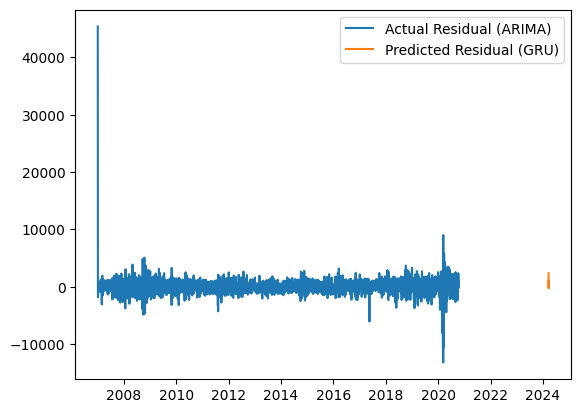

In [ ]:
plt.plot(residual_arima.index, residual_arima.values, label = 'Actual Residual (ARIMA)')
plt.plot(data2test.index, residual_gru, label = 'Predicted Residual (GRU)')
plt.legend()
plt.show()

In [ ]:
residual_arima = model.resid()
scaler = MinMaxScaler(feature_range=(0, 1))
residual_arima_normalized = scaler.fit_transform(residual_arima.values.reshape(-1, 1))

In [ ]:
model_gru = Sequential()
model_gru.add(LSTM(units= 50, return_sequences=True, input_shape = (residual_arima_normalized.shape[1], 1)))
model_gru.add(LSTM(units=50))
model_gru.add(Dense(units=1))